In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [ ]:
!wget "https://www.boredpanda.com/blog/wp-content/uploads/2020/07/shiba-cheems-meme-dog-balltze-5-5f030ec3cf823__700.jpg" -O original.jpg

--2023-08-01 17:17:51--  https://www.boredpanda.com/blog/wp-content/uploads/2020/07/shiba-cheems-meme-dog-balltze-5-5f030ec3cf823__700.jpg
Resolving www.boredpanda.com (www.boredpanda.com)... 99.84.252.100, 99.84.252.120, 99.84.252.47, ...
Connecting to www.boredpanda.com (www.boredpanda.com)|99.84.252.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65613 (64K) [image/jpeg]
Saving to: ‘original.jpg’

original.jpg        100%[===================>]  64.08K  --.-KB/s    in 0.05s   

2023-08-01 17:17:52 (1.28 MB/s) - ‘original.jpg’ saved [65613/65613]



In [ ]:
IMAGE_PATH = "original.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"


In [ ]:
def preprocess_image(image_path):
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
def downscale_image(image):
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))
  lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))
  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
model = hub.load(SAVED_MODEL_PATH)
hr_image = preprocess_image(IMAGE_PATH)
lr_image = downscale_image(tf.squeeze(hr_image))
fake_image = model(lr_image)

In [ ]:
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)

PSNR: 31.986044


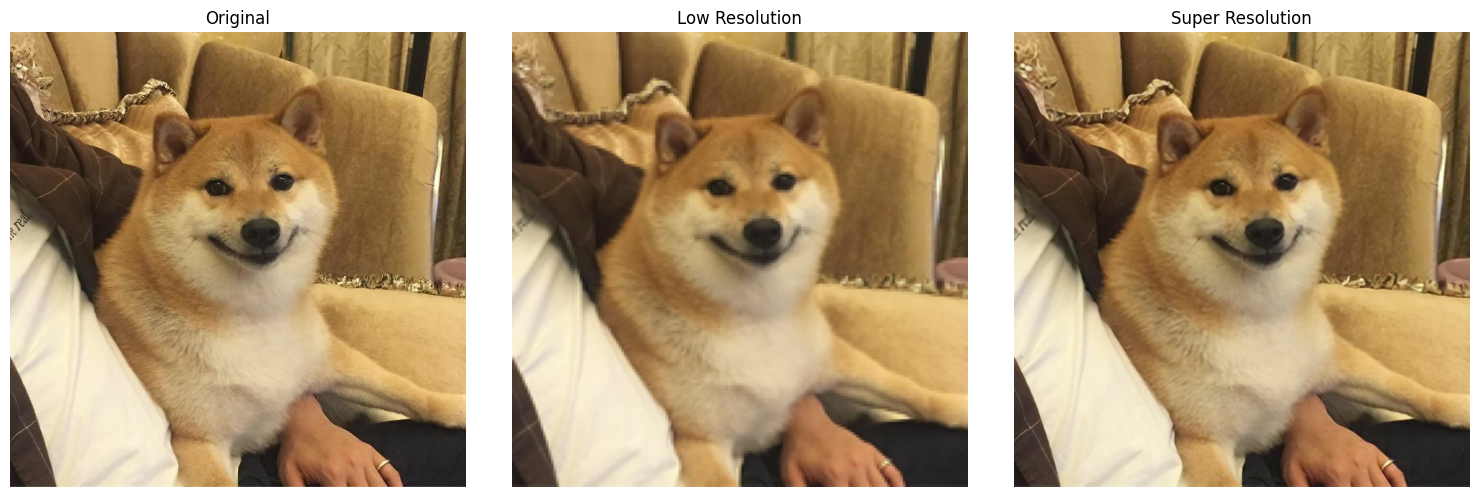

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "Low Resolution")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
print("PSNR: %f" % psnr)